# **Sales Data Analysis**
Sales analysis is mining your data to evaluate the performance of your sales team against its goals. It provides insights about the top performing and underperforming products/services, the problems in selling and market opportunities, sales forecasting, and sales activities that generate revenue.

Regular sales data analysis provides an understanding of the products that your customers are buying and helps you dissect why they are behaving in a certain way. You can also find patterns in your lead conversions and drop offs. All of these aspects enable you to optimize your sales process.


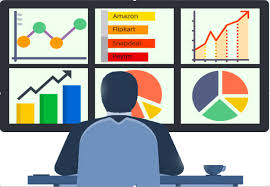



Dataset which are being used are from https://www.kaggle.com/rishabh25126/sales-analysis-2019


Import some essential libraries

In [ ]:
import numpy as np # Linear algebra
import pandas as pd # For manipulating data
import matplotlib.pyplot as plt # For plotting
import seaborn as sns # For plotting
import os # For accessing system files

# **Data Preprocessing**
There are total of 12 CSV files for each month so we need to merge all the data to the single CSV file

In [ ]:
# Listing all the files
root_dir = '../input/sales-analysis-2019/'
files = [file for file in os.listdir(root_dir)]

# Creating an empty DataFrame for storing all the data
all_months_data = pd.DataFrame() 

# Merging all the CSV files
for file in files:
    df = pd.read_csv(root_dir + file)
    all_months_data = pd.concat([all_months_data, df])
    
# Saving the file to do further analysis
all_months_data.to_csv('all_data.csv', index = False)

Now let's read the merged CSV file from the disk

In [ ]:
all_data = pd.read_csv('all_data.csv')
all_data.head()

### Dealing with missing values

In [ ]:
# Total NaN in columns
all_data.isnull().sum()

In [ ]:
# Dropping the NaN
all_data.dropna(inplace=True)

### Augmenting data with extra columns

In [ ]:
# Add month column
all_data['Month'] = all_data['Order Date'].str[0:2]
try:
    all_data['Month'] = all_data['Month'].astype(np.int32)
except Exception as e:
    print(e)

Before we need to go further their are some **0r** in out data which are giving the error... so let's fix this first

In [ ]:
# Finding the Or in Month column
temp_df = all_data[all_data['Order Date'].str[0:2] == 'Or']
temp_df.head()

In [ ]:
# Removing Or data
all_data = all_data[all_data['Order Date'].str[0:2] != 'Or']

Now, as the **Or** is being removed we can again do the **Month** operation

In [ ]:
# Againg adding the month column

all_data['Month'] = all_data['Order Date'].str[0:2]
all_data['Month'] = all_data['Month'].astype(np.int32)

### Converting some columns to numeric columns and Augmenting the Sales Column to our dataset

In [ ]:
# Converting price column to numeric column
all_data['Price Each'] = all_data['Price Each'].astype(np.float64)

# Converting Quantity column to numeric column
all_data['Quantity Ordered'] = all_data['Quantity Ordered'].astype(np.int64)

# Adding sales Columns
all_data['Sales'] = all_data['Quantity Ordered'] * all_data['Price Each']

### At last lets check the data-type and null values in our data

In [ ]:
# Checking the data type of every column
all_data.info()

# Q1: What was the best month for sales? and how much was earned that month?

In [ ]:
# Freuency of the months in sales
results = all_data.groupby('Month').sum()
results

We got the result... but its better to visulize our data to get good insight.

In [ ]:
# plotting the sales result

months = range(1,13)
plt.bar(months, results['Sales'])
plt.title('Sales per Month')
plt.xticks(months)
plt.ylabel('Sales in USD')
plt.xlabel('Months')
plt.show();

In [ ]:
results['Month'] = results.index

sns.lineplot(x='Month', y='Sales', data=results, color='red', markers='--')

plt.xticks(months)
plt.title('Sales per Month')
plt.xlabel('Months for Sales')
plt.ylabel('Sales in USD($)')
plt.show()

# Q2: What city had the highest number of sales?

### Augmenting the data with City column for further analysis

In [ ]:
# Adding Cities column

all_data['City'] = all_data['Purchase Address']
all_data['State'] = all_data['Purchase Address']
def adding_city_and_state(a):
    return f"{a.split(',')[1][1:]} ({a.split(',')[2][1:3]})"
 
all_data['City'] = all_data['City'].apply(adding_city_and_state)
all_data['City'].head()

In [ ]:
# Grouping via City
results = all_data.groupby('City').sum()
results[results['Sales'] == results['Sales'].max()]

Here we can see that San Francisco (CA)	has the highest number of sales.

In [ ]:
# plotting the resulted sales

cities = [city for city, _ in all_data.groupby('City')]

plt.bar(cities, results['Sales'])
plt.xticks(cities, rotation='vertical')
plt.ylabel('Sales in USD')
plt.xlabel('City Name')
plt.show();

In [ ]:
results['City'] = results.index

sns.lineplot(x='City', y='Sales', data=results, color='red')

plt.xticks(cities, rotation='vertical')
plt.title('Sales per City')
plt.xlabel('City for Sales')
plt.ylabel('Sales in USD($)')
plt.show()

# **Q3: What time should we display advertisements to maximize likelihood of customer's buying product?**

In [ ]:
# Converting Order Date to date time field using pandas to_datetime

all_data['Order Date'] = pd.to_datetime(all_data['Order Date'])
all_data.head()

In [ ]:
# Adding Hours column in our dataset
all_data['Hour'] = all_data['Order Date'].dt.hour

# Adding Minute column in our dataset
all_data['Minute'] = all_data['Order Date'].dt.minute

all_data.head()

In [ ]:
hours = [hour for hour, _ in all_data.groupby('Hour')]

plt.plot(hours, all_data.groupby(['Hour']).count())
plt.xticks(hours)
plt.xlabel("Hours ----->")
plt.ylabel("Number of Orders ----->")
plt.grid()
plt.show();

From this we can say that the sales are high in morning between 11am-12am and evening 6pm-8pm. So we should advertise some what after those periods.

# Q4 What products are most often sold together?

In [ ]:
# Capturing all the duplicate Order ID to find out which are boughts in pairs

temp = all_data[all_data['Order ID'].duplicated(keep=False)]
temp.head(10)

In [ ]:
# adding Grouped column which will tell us what products are sold with the same Order Id

temp['Grouped'] = temp.groupby('Order ID')['Product'].transform(lambda x: ','.join(x))
temp.head()

In [ ]:
# Removing the duplicates from the dataset

temp = temp[['Order ID', 'Grouped']].drop_duplicates()
temp.head()

In [ ]:
# Counting the frequency of occurence of two products together

from itertools import combinations
from collections import Counter

count = Counter()

for row in temp['Grouped']:
    row_list = list(row.split(','))
    count.update(Counter(combinations(row_list, 2)))
items = []
items_count = []
for key, value in count.most_common(10):
    items.append(str(key))
    items_count.append(int(value))
    print(f"{str(key)[1:-1]} : {str(value)}")

item_len = range(1, len(items)+1)
plt.bar(item_len, items_count)
plt.xticks(item_len, rotation='vertical')
plt.show()
    

Here we can see that 'iPhone', 'Lightning Charging Cable' are sold often together

In [ ]:
# Uploading my notebook to my jovian.ml account
!pip install jovian
import jovian
jovian.commit(project='eda_on_sales_analysis_2019')